In [83]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1)

## Dataset
Download the dataset from [here](https://ai.stanford.edu/~amaas/data/sentiment/). Then `unzip` the downloaded zipped file in the present workin working directory.  

In [84]:
!tar -xf aclImdb_v1.tar.gz

In [85]:
# read sentiments and reviews data from text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding='utf8') as f:
            review_list.append(f.read())
            label_list.append(label)
print('Number of reviews:', len(review_list))

100%|██████████| 12500/12500 [00:03<00:00, 3571.55it/s]

Number of reviews: 25000


In [86]:
# pre-processing review text
## lower
review_list = [review.lower() for review in review_list]
## remove punctuation
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

100%|██████████| 25000/25000 [00:03<00:00, 8099.26it/s]


In [87]:
review_list[0]

'for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagine a movie where joe piscopo is actually funny maureen stapleton is a scene stealer the moroni character is an absolute scream watch for alan the skipper hale jr as a police sgt'

In [88]:
# accumulate all review texts together
all_reviews = ' '.join(review_list)
# generate list of all words of all reviews
review_words = all_reviews.split()
# get the word counts
words_count = Counter(review_words)

# sort words as per counts
num_review_words = len(review_words)
sorted_review_words = words_count.most_common(num_review_words)

print(sorted_review_words[:5])

[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042)]


In [89]:
# create word to token dictionary in order to encode text as numbers.
vocab_to_token = { word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
vocab_to_token.items()

dict_items([('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10), ('that', 11), ('br', 12), ('was', 13), ('as', 14), ('for', 15), ('with', 16), ('movie', 17), ('but', 18), ('film', 19), ('on', 20), ('not', 21), ('you', 22), ('are', 23), ('his', 24), ('have', 25), ('he', 26), ('be', 27), ('one', 28), ('its', 29), ('at', 30), ('all', 31), ('by', 32), ('an', 33), ('they', 34), ('from', 35), ('who', 36), ('so', 37), ('like', 38), ('her', 39), ('just', 40), ('or', 41), ('about', 42), ('has', 43), ('if', 44), ('out', 45), ('some', 46), ('there', 47), ('what', 48), ('good', 49), ('when', 50), ('more', 51), ('very', 52), ('even', 53), ('she', 54), ('my', 55), ('no', 56), ('up', 57), ('would', 58), ('which', 59), ('only', 60), ('time', 61), ('really', 62), ('story', 63), ('their', 64), ('were', 65), ('had', 66), ('see', 67), ('can', 68), ('me', 69), ('than', 70), ('we', 71), ('much', 72), ('well', 73), ('been', 74), ('get', 75), ('will'

In [90]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print(reviews_tokenized[0])

for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagine a movie where joe piscopo is actually funny maureen stapleton is a scene stealer the moroni character is an absolute scream watch for alan the skipper hale jr as a police sgt

[15, 3, 17, 11, 201, 56, 1165, 47, 242, 23, 3, 168, 4, 891, 4325, 3513, 15, 10, 1514, 822, 3, 17, 112, 884, 14623, 6, 155, 161, 7307, 15816, 6, 3, 134, 20049, 1, 32064, 108, 6, 33, 1492, 1943, 103, 15, 1550, 1, 18993, 9055, 1809, 14, 3, 549, 6906]


In [91]:
# encode label
encoded_label_list = [1 if label == 'pos' else 0 for label in label_list]
# create a list which contains each review's len
reviews_len = [len(review) for review in reviews_tokenized]
# remove review which len < 1
reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]

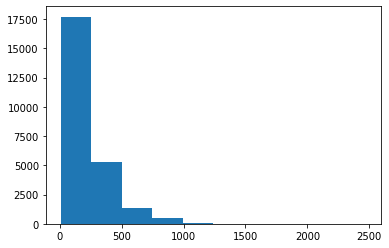

In [92]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

plt.hist(reviews_len);

In [93]:
padded_reviews[0].shape

(512,)

In [94]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

# to numpy type
train_X = np.array(train_X)
train_y = np.array(train_y)
validation_X = np.array(validation_X)
validation_y = np.array(validation_y)

In [95]:
# generate torch datasets
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))

batch_size = 32
# torch dataloaders (shuffle data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [96]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = train_data_iter.next()
print('Exameple Input size:', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Exameple Output size:', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Exameple Input size: torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,    51,   247,    61],
        [    0,     0,     0,  ...,    10,  2229,    12],
        [    0,     0,     0,  ...,     1,   166,   530],
        ...,
        [    0,     0,     0,  ...,    28,     3,  9755],
        [    0,     0,     0,  ...,    12, 61819, 61820],
        [    0,     0,     0,  ...,    58, 21368, 20239]])

Exameple Output size: torch.Size([32])
Example Output:
 tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1])


In [97]:

class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)  
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))      
        return final_output
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [98]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

In [99]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader:
        optim.zero_grad()     
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment.float())
        accuracy_curr = accuracy_metric(preds, sentiment.float())
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [100]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            preds = model(sequence.T).squeeze()
            loss_curr = loss_func(preds.float(), sentiment.float())   
            accuracy_curr = accuracy_metric(preds.float(), sentiment.float())

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
    return loss/len(dataloader), accuracy/len(dataloader)

In [101]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 169.88982129096985s
training loss: 0.625 | training accuracy: 66.02%
validation loss: 0.953 |  validation accuracy: 24.48%

epoch number: 2 | time elapsed: 180.7015130519867s
training loss: 0.533 | training accuracy: 74.02%
validation loss: 0.945 |  validation accuracy: 47.13%

epoch number: 3 | time elapsed: 171.36499094963074s
training loss: 0.430 | training accuracy: 81.07%
validation loss: 0.770 |  validation accuracy: 64.04%

epoch number: 4 | time elapsed: 186.9883451461792s
training loss: 0.370 | training accuracy: 84.66%
validation loss: 0.776 |  validation accuracy: 61.37%

epoch number: 5 | time elapsed: 193.8556022644043s
training loss: 0.301 | training accuracy: 88.04%
validation loss: 0.955 |  validation accuracy: 60.26%

epoch number: 6 | time elapsed: 217.7382938861847s
training loss: 0.285 | training accuracy: 88.76%
validation loss: 0.924 |  validation accuracy: 61.54%

epoch number: 7 | time elapsed: 210.1798300743103s
training loss: 0.

In [104]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

In [105]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "Decent movie, although could be shorter"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I loved the movie, every part of it"))

0.0018341446993872523
0.031147785484790802
0.0023882349487394094
0.09339746087789536
0.03484150767326355
